## Stock Price Prediction using LSTM & RHN with Feature Engineering & Hyperparameter Tuning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import yfinance as yf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Layer
from keras.wrappers.scikit_learn import KerasRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Download historical stock data
ticker = "GOOGL"
start_date = "2018-01-01"
end_date = "2023-10-31"
#df = pdr.get_data_yahoo(ticker, start=start_date, end=end_date)
df = yf.download(ticker, start=start_date, end=end_date, progress=False)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,52.651001,53.799000,52.651001,53.660500,53.660500,31766000
2018-01-03,53.696499,54.805000,53.671501,54.576000,54.576000,31318000
2018-01-04,54.854500,55.203999,54.713001,54.787998,54.787998,26052000
2018-01-05,55.172501,55.679001,55.090000,55.514500,55.514500,30250000
2018-01-08,55.549999,55.958000,55.500000,55.710499,55.710499,24644000
...,...,...,...,...,...,...
2023-10-24,137.830002,139.360001,137.419998,138.809998,138.809998,44814300
2023-10-25,128.160004,128.309998,125.070000,125.610001,125.610001,84366200
2023-10-26,123.269997,124.330002,121.269997,122.279999,122.279999,57061100


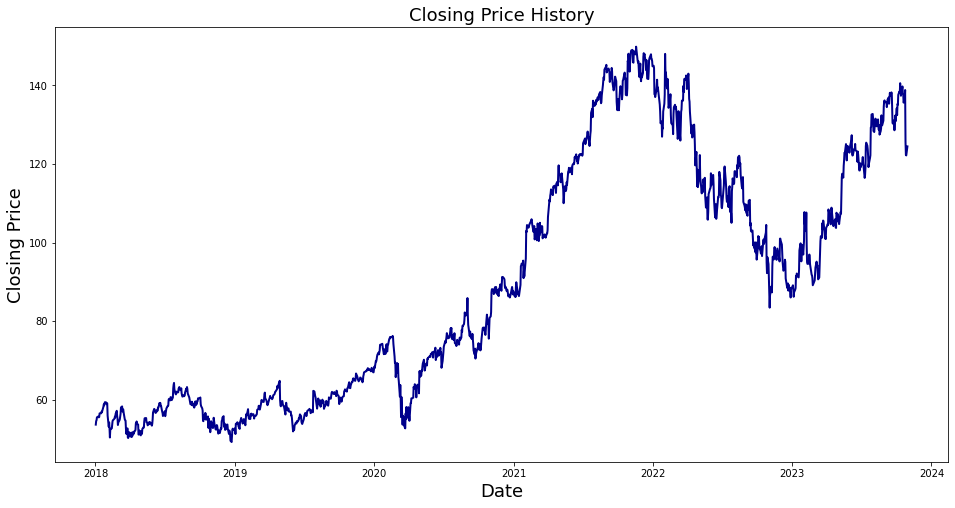

In [3]:
# Plot the closing price history
plt.figure(figsize=(16,8))
plt.title('Closing Price History', fontsize=18)
plt.plot(df['Close'], linewidth=2, color='darkblue')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price', fontsize=18)
plt.show()

In [4]:
# Feature Engineering
df['Return'] = df['Close'].pct_change() # Simple daily return
df['Moving_Avg_5'] = df['Close'].rolling(window=5).mean() # 5-day moving average
df['Moving_Avg_10'] = df['Close'].rolling(window=10).mean() # 10-day moving average
df['Moving_STD_10'] = df['Close'].rolling(window=10).std() # 10-day moving standard deviation

# Replace NA values with 0
df.fillna(0, inplace=True)

df.head(30)

,Open,High,Low,Close,Adj Close,Volume,Return,Moving_Avg_5,Moving_Avg_10,Moving_STD_10
Date,,,,,,,,,,
2018-01-02,52.651001,53.799000,52.651001,53.660500,53.660500,31766000,0.000000,0.000000,0.000000,0.000000
2018-01-03,53.696499,54.805000,53.671501,54.576000,54.576000,31318000,0.017061,0.000000,0.000000,0.000000
2018-01-04,54.854500,55.203999,54.713001,54.787998,54.787998,26052000,0.003884,0.000000,0.000000,0.000000
2018-01-05,55.172501,55.679001,55.090000,55.514500,55.514500,30250000,0.013260,0.000000,0.000000,0.000000
2018-01-08,55.549999,55.958000,55.500000,55.710499,55.710499,24644000,0.003531,54.849899,0.000000,0.000000
2018-01-09,55.922001,55.922001,55.410000,55.639500,55.639500,26808000,-0.001274,55.245699,0.000000,0.000000
2018-01-10,55.349998,55.639000,55.199001,55.507000,55.507000,20734000,-0.002381,55.431899,0.000000,0.000000
2018-01-11,55.615501,55.742500,55.324001,55.602501,55.602501,22424000,0.001721,55.594800,0.000000,0.000000
2018-01-12,55.505001,56.564999,55.400501,56.532501,56.532501,38586000,0.016726,55.798400,0.000000,0.000000


In [5]:
# Removing first 9 rows since they contain 0 values
df1 = df[9:]

df1.head()

,Open,High,Low,Close,Adj Close,Volume,Return,Moving_Avg_5,Moving_Avg_10,Moving_STD_10
Date,,,,,,,,,,
2018-01-16,57.015499,57.444000,56.3330,56.535000,56.535000,36462000,0.000044,55.963300,55.40660,0.873630
2018-01-17,56.818001,56.966000,56.1745,56.955002,56.955002,27830000,0.007429,56.226401,55.73605,0.755158
2018-01-18,56.967499,57.029499,56.2230,56.798500,56.798500,27498000,-0.002748,56.484701,55.95830,0.700913
2018-01-19,56.901501,57.188999,56.6250,57.174999,57.174999,30552000,0.006629,56.799200,56.19700,0.663533
2018-01-22,57.191002,58.344002,57.0910,58.208000,58.208000,29550000,0.018067,57.134300,56.46635,0.870204


In [6]:
# Define the features and the target variable
features = ['Open', 'High', 'Low', 'Return', 'Moving_Avg_5', 'Moving_Avg_10', 'Moving_STD_10']

X = df1[features]
y = df1['Close']

# Feature Scaling
feature_scaler = MinMaxScaler()
X_scaled = feature_scaler.fit_transform(X)

target_scaler = MinMaxScaler()
y_scaled = target_scaler.fit_transform(y.values.reshape(-1,1))

In [7]:
# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False, random_state=42)

In [8]:
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (1166, 7)
y_train shape:  (1166, 1)
X_test shape:  (292, 7)
y_test shape:  (292, 1)


In [9]:
# Since LSTM expects a 3D array as input, we need to reshape the data
X_train_lstm = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lstm = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [10]:
print("X_train_lstm shape: ", X_train_lstm.shape)
print("X_test_lstm shape: ", X_test_lstm.shape)

X_train_lstm shape:  (1166, 1, 7)
X_test_lstm shape:  (292, 1, 7)


In [11]:
# Create a Estimator class for LSTM model
class LSTMEstimator(BaseEstimator, RegressorMixin):
    def __init__(self, optimizer='adam'):
        self.optimizer = optimizer
        self.model = Sequential()
        self.model.add(LSTM(100, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(1))
        self.model.compile(optimizer=self.optimizer, loss='mse')

    def fit(self, X, y):
        self.model.fit(X, y, epochs=100, batch_size=64, verbose=0)
        return self

    def predict(self, X):
        return self.model.predict(X).flatten()
    
# Create the LSTM model
lstm_model = LSTMEstimator()
lstm_model.fit(X_train_lstm, y_train)

LSTMEstimator()

In [12]:
class RHNL(Layer):
    def __init__(self, units, depth, **kwargs):
        super(RHNL, self).__init__(**kwargs)
        self.units = units
        self.depth = depth

    def build(self, input_shape):
        self.W_h = self.add_weight(name='W_h', shape=(input_shape[-1], self.units), 
                                   initializer='uniform', trainable=True)
        
        self.W_t = [self.add_weight(name=f'W_t_{i}', shape=(self.units, self.units),
                                    initializer='uniform', trainable=True) for i in range(self.depth)]
        
        self.W_c = [self.add_weight(name=f'W_c_{i}', shape=(self.units, self.units),
                                    initializer='uniform', trainable=True) for i in range(self.depth)]
    
    def call(self, x):
        h = tf.matmul(x, self.W_h)
        for i in range(self.depth):
            t = tf.sigmoid(tf.matmul(h, self.W_t[i]))
            c = tf.tanh(tf.matmul(h, self.W_c[i]))
            h = h * t + c * (1 - t)
        return h
    
    def get_config(self):
        config = super().get_config()
        config.update({'units': self.units, 'depth': self.depth})
        return config

In [13]:
def create_rhn_model(rhn_units=64, rhn_depth=1, output_units=1):
    model = Sequential()
    model.add(RHNL(rhn_units, rhn_depth, input_shape=(X_train.shape[1], )))
    model.add(Dense(output_units, activation='linear'))
    model.compile(loss='mse', optimizer='adam')
    return model

# Create the model
rhn_model = create_rhn_model()
rhn_model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1, validation_data=(X_test, y_test))

Epoch 1/100
19/19 [==============================] - 1s 11ms/step - loss: 0.0856 - val_loss: 0.0100
Epoch 2/100
19/19 [==============================] - 0s 3ms/step - loss: 0.0093 - val_loss: 0.0053
Epoch 3/100
19/19 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 4/100
19/19 [==============================] - 0s 3ms/step - loss: 5.4678e-04 - val_loss: 4.8585e-04
Epoch 5/100
19/19 [==============================] - 0s 3ms/step - loss: 2.2042e-04 - val_loss: 3.7132e-04
Epoch 6/100
19/19 [==============================] - 0s 3ms/step - loss: 1.8460e-04 - val_loss: 3.2364e-04
Epoch 7/100
19/19 [==============================] - 0s 3ms/step - loss: 1.5984e-04 - val_loss: 2.8320e-04
Epoch 8/100
19/19 [==============================] - 0s 4ms/step - loss: 1.4337e-04 - val_loss: 2.5247e-04
Epoch 9/100
19/19 [==============================] - 0s 3ms/step - loss: 1.3304e-04 - val_loss: 2.3923e-04
Epoch 10/100
19/19 [==============================] - 0s 3ms

In [14]:
# Make predictions
pred_lstm = lstm_model.predict(X_test_lstm)
pred_rhn = rhn_model.predict(X_test)

10/10 [==============================] - 0s 1ms/step


In [15]:
# Create a stacked model
stacked_pred = np.column_stack((pred_lstm, pred_rhn))

# Train final regressor based on stacked predictions
final_regressor = LinearRegression().fit(stacked_pred, y_test)

final_pred = final_regressor.predict(stacked_pred)

In [16]:
# Denormalize the predictions
pred_lstm_inv = target_scaler.inverse_transform(lstm_model.predict(X_test_lstm).reshape(-1,1))
pred_rhn_inv = target_scaler.inverse_transform(rhn_model.predict(X_test).reshape(-1,1))
final_pred_inv = target_scaler.inverse_transform(final_pred.reshape(-1,1))
y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1,1))

10/10 [==============================] - 0s 1000us/step


In [17]:
# Calculate the Evaluatioon metrics for LSTM model
lstm_mse = mean_squared_error(y_test_inv, pred_lstm_inv)
lstm_rmse = np.sqrt(lstm_mse)
lstm_mae = mean_absolute_error(y_test_inv, pred_lstm_inv)
lstm_r2 = r2_score(y_test_inv, pred_lstm_inv)

print("Evaluation Metrics for LSTM Model")
print("=================================")
print("MSE: {:.4f}".format(lstm_mse))
print("RMSE: {:.4f}".format(lstm_rmse))
print("MAE: {:.4f}".format(lstm_mae))
print("R2 Score: {:.4f}".format(lstm_r2))

Evaluation Metrics for LSTM Model
MSE: 1.7973
RMSE: 1.3406
MAE: 1.0417
R2 Score: 0.9931


In [18]:
# Calculate the Evaluatioon metrics for RHN model
rhn_mse = mean_squared_error(y_test_inv, pred_rhn_inv)
rhn_rmse = np.sqrt(rhn_mse)
rhn_mae = mean_absolute_error(y_test_inv, pred_rhn_inv)
rhn_r2 = r2_score(y_test_inv, pred_rhn_inv)

print("Evaluation Metrics for RHN Model")
print("=================================")
print("MSE: {:.4f}".format(rhn_mse))
print("RMSE: {:.4f}".format(rhn_rmse))
print("MAE: {:.4f}".format(rhn_mae))
print("R2 Score: {:.4f}".format(rhn_r2))

Evaluation Metrics for RHN Model
MSE: 0.5713
RMSE: 0.7558
MAE: 0.6028
R2 Score: 0.9978


In [19]:
# Calculate the Evaluatioon metrics for Stacked model
stacked_mse = mean_squared_error(y_test_inv, final_pred_inv)
stacked_rmse = np.sqrt(stacked_mse)
stacked_mae = mean_absolute_error(y_test_inv, final_pred_inv)
stacked_r2 = r2_score(y_test_inv, final_pred_inv)

print("Evaluation Metrics for Stacked Model")
print("====================================")
print("MSE: {:.4f} ".format(stacked_mse))
print("RMSE: {:.4f}".format(stacked_rmse))
print("MAE: {:.4f}".format(stacked_mae))
print("R2 Score: {:.4f}".format(stacked_r2))

Evaluation Metrics for Stacked Model
MSE: 0.5113 
RMSE: 0.7150
MAE: 0.5780
R2 Score: 0.9980


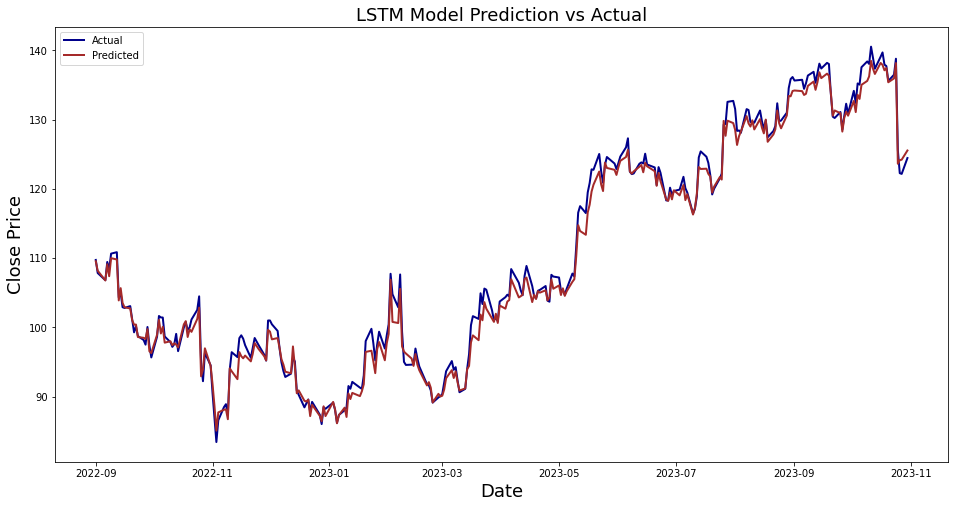

In [40]:
# Plot the predictions of LSTM model without Hyperparameter tuning
plt.figure(figsize=(16,8))
plt.title('LSTM Model Prediction vs Actual', fontsize=18)
plt.plot(df1.index[-len(y_test):], y_test_inv, linewidth=2, color='darkblue', label='Actual')
plt.plot(df1.index[-len(y_test):], pred_lstm_inv, linewidth=2, color='brown', label='Predicted')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.legend(loc='best')
plt.show()

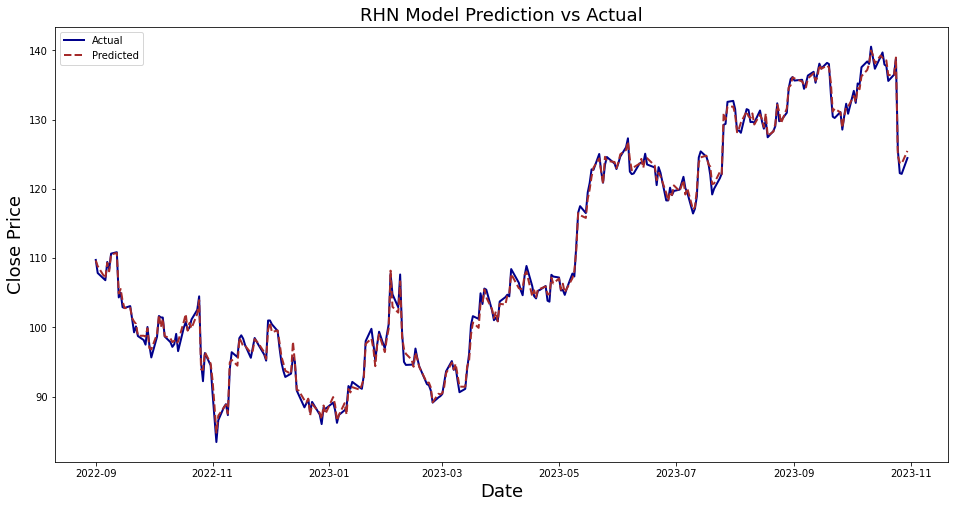

In [41]:
# Plot the predictions of RHN model without Hyperparameter tuning
plt.figure(figsize=(16,8))
plt.title('RHN Model Prediction vs Actual', fontsize=18)
plt.plot(df1.index[-len(y_test):], y_test_inv, linewidth=2, color='darkblue', label='Actual')
plt.plot(df1.index[-len(y_test):], pred_rhn_inv, linewidth=2, color='brown', label='Predicted', linestyle='--')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.legend(loc='best')
plt.show()

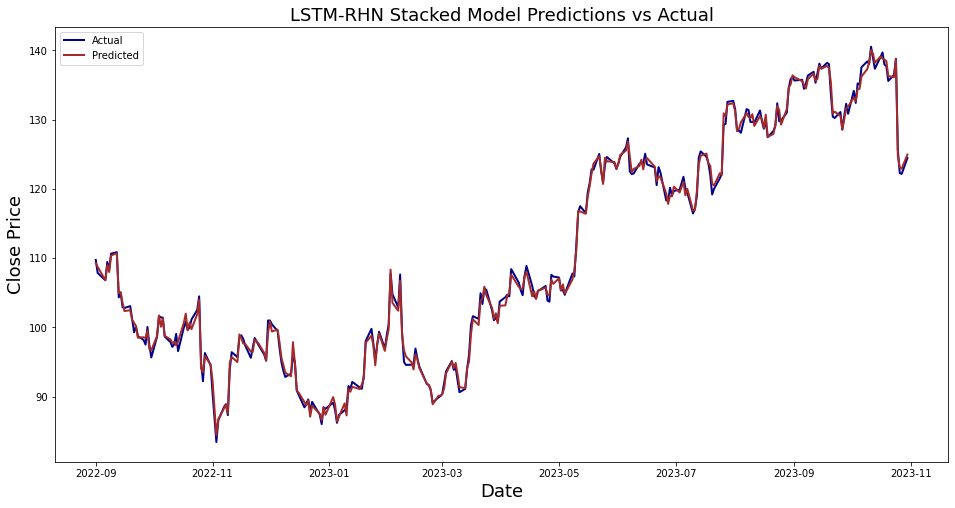

In [42]:
# Plot the predictions of Stacked model without Hyperparameter tuning
plt.figure(figsize=(16,8))
plt.title('LSTM-RHN Stacked Model Predictions vs Actual', fontsize=18)
plt.plot(df1.index[-len(y_test):], y_test_inv, linewidth=2, color='darkblue', label='Actual')
plt.plot(df1.index[-len(y_test):], final_pred_inv, linewidth=2, color='brown', label='Predicted')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.legend(loc='best')
plt.show()

In [23]:
# Build a dataframe with actual and predicted prices
df_pred = pd.DataFrame({'Date': df1.index[-len(y_test):], 'Actual': y_test_inv.flatten(),'LSTM': pred_lstm_inv.flatten(), 'RHN': pred_rhn_inv.flatten(), 'Stacked': final_pred_inv.flatten()})
df_pred

,Date,Actual,LSTM,RHN,Stacked
0,2022-09-01,109.739998,109.540733,109.652664,109.286926
1,2022-09-02,107.849998,108.181488,108.847893,108.725815
2,2022-09-06,106.809998,106.774773,107.071510,106.800140
3,2022-09-07,109.449997,109.115768,109.316940,108.991592
4,2022-09-08,108.379997,107.390221,108.092834,107.990669
...,...,...,...,...,...
287,2023-10-24,138.809998,138.184204,138.983719,138.747513
288,2023-10-25,125.610001,123.634117,124.753029,124.735535
289,2023-10-26,122.279999,124.163635,123.767433,123.102257
290,2023-10-27,122.169998,124.221161,123.656281,122.919006


In [24]:
# Take the last day of data for predictions
last_features = X_scaled[-1:]

predicted_prices_lstm = []

# Predicting stock prices for the next 2 days
for _ in range(2):
    # Prepare the last features for LSTM input shape
    last_features_lstm = last_features.reshape(1, 1, X_train_lstm.shape[2])
    
    # Predicting the next day stock price using the last feature data
    predicted_price = lstm_model.predict(last_features_lstm)
    
    # Reshape the predicted price for inverse scaling
    predicted_price_reshaped = predicted_price.reshape(-1, 1)
    
    # Saving the predicted price after inverse transformation
    inverse_transformed_price = target_scaler.inverse_transform(predicted_price_reshaped)[0][0]
    predicted_prices_lstm.append(inverse_transformed_price)

    # Computing new features based on the predicted price
    new_features = np.array([
        last_features[0, 1],  # 'Open' value for the next day (shifted from 'High' of the current day)
        last_features[0, 2],  # 'High' value for the next day (shifted from 'Low' of the current day)
        predicted_price_reshaped[0, 0], # 'Low' value (using the predicted closing price as an approximation)
        (predicted_price_reshaped[0, 0] - last_features[0, 3]) / last_features[0, 3],  # Return for the predicted day
        np.mean(np.append(last_features[0, 4:6], predicted_price_reshaped[0, 0])),  # 5-day moving average
        np.mean(np.append(last_features[0, 5:], predicted_price_reshaped[0, 0])),  # 10-day moving average
        np.std(np.append(last_features[0, 6:], predicted_price_reshaped[0, 0]))    # 10-day moving standard deviation
    ], dtype=np.float32).reshape(1, 7)

    last_features = new_features

print("Predicted Closing Prices for the Next 2 Days (LSTM Model):")
for i, price in enumerate(predicted_prices_lstm):
    print(f"Day {i+1}:" "{:.3f}".format(price))

1/1 [==============================] - 0s 22ms/step
Predicted Closing Prices for the Next 2 Days (LSTM Model):
Day 1:125.550
Day 2:122.093


In [25]:
last_features = X_scaled[-1:]

# Predict using the RHN model
predicted_prices_rhn = []

last_features_rhn = last_features.copy()

for _ in range(2):
    # Predicting the next day stock price using the last feature data
    predicted_price_rhn = rhn_model.predict(last_features_rhn)
    
    # Reshape the predicted price for inverse scaling
    predicted_price_reshaped_rhn = predicted_price_rhn.reshape(-1, 1)
    
    # Saving the predicted price after inverse transformation
    inverse_transformed_price_rhn = target_scaler.inverse_transform(predicted_price_reshaped_rhn)[0][0]
    predicted_prices_rhn.append(inverse_transformed_price_rhn)

    # Computing new features based on the predicted price
    # Here we reuse the logic for LSTM for simplicity. Depending on the scenario, the exact methodology might change.
    new_features_rhn = np.array([
        last_features_rhn[0, 1], 
        last_features_rhn[0, 2], 
        predicted_price_reshaped_rhn[0, 0], 
        (predicted_price_reshaped_rhn[0, 0] - last_features_rhn[0, 3]) / last_features_rhn[0, 3],
        np.mean(np.append(last_features_rhn[0, 4:6], predicted_price_reshaped_rhn[0, 0])),
        np.mean(np.append(last_features_rhn[0, 5:], predicted_price_reshaped_rhn[0, 0])),
        np.std(np.append(last_features_rhn[0, 6:], predicted_price_reshaped_rhn[0, 0]))
    ], dtype=np.float32).reshape(1, 7)

    last_features_rhn = new_features_rhn

print("\nPredicted Closing Prices for the Next 2 Days (RHN Model):")
for i, price in enumerate(predicted_prices_rhn):
    print(f"Day {i+1}:" "{:.3f}".format(price))


1/1 [==============================] - 0s 20ms/step

Predicted Closing Prices for the Next 2 Days (RHN Model):
Day 1:125.493
Day 2:122.812


In [26]:
last_features = X_scaled[-1:]

# Predict using the Stacked LSTM-RHN model
predicted_prices_stacked = []

for day in range(2):
    # Reshape the last features for LSTM input shape
    last_features_lstm = last_features.reshape(1, 1, X_train_lstm.shape[2])
    
    # Predict using LSTM & RHN models
    lstm_pred_for_stacking = lstm_model.predict(last_features_lstm).flatten()
    rhn_pred_for_stacking = rhn_model.predict(last_features).flatten()

    # Stacking LSTM and RHN predictions
    stacked_predictions = np.column_stack((lstm_pred_for_stacking, rhn_pred_for_stacking))
    
    # Predict using the final regressor
    predicted_stacked = final_regressor.predict(stacked_predictions)

    # Reshape the predicted price for inverse scaling
    predicted_price_reshaped_stacked = predicted_stacked.reshape(-1, 1)
    
    # Saving the predicted price after inverse transformation
    inverse_transformed_price_stacked = target_scaler.inverse_transform(predicted_price_reshaped_stacked)[0][0]
    predicted_prices_stacked.append(inverse_transformed_price_stacked)

    # For the next prediction, update the features with the newly predicted price.
    # We reuse the logic from LSTM to compute new features for simplicity.
    new_features_stacked = np.array([
        last_features[0, 1], 
        last_features[0, 2], 
        predicted_price_reshaped_stacked[0, 0], 
        (predicted_price_reshaped_stacked[0, 0] - last_features[0, 3]) / last_features[0, 3],
        np.mean(np.append(last_features[0, 4:6], predicted_price_reshaped_stacked[0, 0])),
        np.mean(np.append(last_features[0, 5:], predicted_price_reshaped_stacked[0, 0])),
        np.std(np.append(last_features[0, 6:], predicted_price_reshaped_stacked[0, 0]))
    ], dtype=np.float32).reshape(1, 7)

    last_features = new_features_stacked

print("\nPredicted Closing Prices for the Next 2 Days (Stacked LSTM-RHN Model):")
for i, price in enumerate(predicted_prices_stacked):
    print(f"Day {i+1}:" "{:.3f}".format(price))

1/1 [==============================] - 0s 22ms/step

Predicted Closing Prices for the Next 2 Days (Stacked LSTM-RHN Model):
Day 1:124.964
Day 2:122.399


In [27]:
# LSTM model with hyperparameter tuning
# Define the parameter grid
param_grid = {'optimizer': ['Adam','RMSprop','SGD']}

# Grid search on LSTM
grid = GridSearchCV(estimator=LSTMEstimator(), param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)
grid_result = grid.fit(X_train_lstm, y_train)

# Print the best parameters
print("Best parameters: ", grid_result.best_params_)
print("Best score: ", grid_result.best_score_)
print("Best estimator: ", grid_result.best_estimator_)

# Using the best estimator for LSTM from the grid search
best_lstm_model = grid_result.best_estimator_

# Predicting the test data
pred_best_lstm = best_lstm_model.predict(X_test_lstm)

# Inverse transform the predictions
pred_best_lstm_inv = target_scaler.inverse_transform(pred_best_lstm.reshape(-1,1))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters:  {'optimizer': 'Adam'}
Best score:  0.9879797558123276
Best estimator:  LSTMEstimator(optimizer='Adam')
10/10 [==============================] - 0s 1ms/step


In [28]:
# Calculate the Evaluatioon metrics for LSTM model
best_lstm_mse = mean_squared_error(y_test_inv, pred_best_lstm_inv)
best_lstm_rmse = np.sqrt(best_lstm_mse)
best_lstm_mae = mean_absolute_error(y_test_inv, pred_best_lstm_inv)
best_lstm_r2 = r2_score(y_test_inv, pred_best_lstm_inv)

print("Tuned LSTM Model Evaluation Metrics")
print("===================================")
print("MSE: {:.4f}".format(best_lstm_mse))
print("RMSE: {:.4f}".format(best_lstm_rmse))
print("MAE: {:.4f}".format(best_lstm_mae))
print("R2 Score: {:.4f}".format(best_lstm_r2))

Tuned LSTM Model Evaluation Metrics
MSE: 0.8851
RMSE: 0.9408
MAE: 0.7591
R2 Score: 0.9966


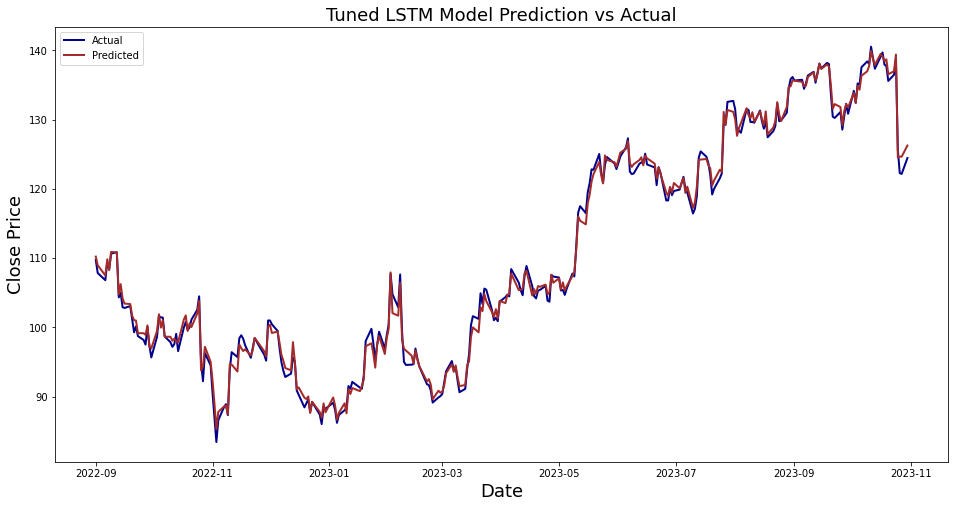

In [43]:
# Plot the predictions of LSTM model with Hyperparameter tuning
plt.figure(figsize=(16,8))
plt.title('Tuned LSTM Model Prediction vs Actual', fontsize=18)
plt.plot(df1.index[-len(y_test):], y_test_inv, linewidth=2, color='darkblue', label='Actual')
plt.plot(df1.index[-len(y_test):], pred_best_lstm_inv, linewidth=2, color='brown', label='Predicted')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.legend(loc='best')
plt.show()

In [30]:
# RHN model with hyperparameter tuning
# Define the parameter grid
param_grid = {'rhn_units': [64, 128, 256], 'rhn_depth': [1, 2, 3]}

# Create the KerasRegressor
rhn_model = KerasRegressor(build_fn=create_rhn_model, epochs=100, batch_size=64, verbose=0)

# Grid search on RHN
grid = GridSearchCV(estimator=rhn_model, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

# Print the best parameters
print("Best parameters: ", grid_result.best_params_)
print("Best score: ", grid_result.best_score_)
print("Best estimator: ", grid_result.best_estimator_)

# Using the best estimator for RHN from the grid search
best_rhn_model = grid_result.best_estimator_

# Predicting the test data
pred_best_rhn = best_rhn_model.predict(X_test)

# Inverse transform the predictions
pred_best_rhn_inv = target_scaler.inverse_transform(pred_best_rhn.reshape(-1,1))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters:  {'rhn_depth': 1, 'rhn_units': 256}
Best score:  -3.6163716504233887e-05
Best estimator:  <keras.wrappers.scikit_learn.KerasRegressor object at 0x000001FAA6846910>


In [31]:
# Calculate the Evaluatioon metrics for RHN model
best_rhn_mse = mean_squared_error(y_test_inv, pred_best_rhn_inv)
best_rhn_rmse = np.sqrt(best_rhn_mse)
best_rhn_mae = mean_absolute_error(y_test_inv, pred_best_rhn_inv)
best_rhn_r2 = r2_score(y_test_inv, pred_best_rhn_inv)

print("Tuned RHN Model Evaluation Metrics")
print("==================================")
print("MSE: {:.4f}".format(best_rhn_mse))
print("RMSE: {:.4f}".format(best_rhn_rmse))
print("MAE: {:.4f}".format(best_rhn_mae))
print("R2 Score: {:.4f}".format(best_rhn_r2))

Tuned RHN Model Evaluation Metrics
MSE: 0.5345
RMSE: 0.7311
MAE: 0.5791
R2 Score: 0.9980


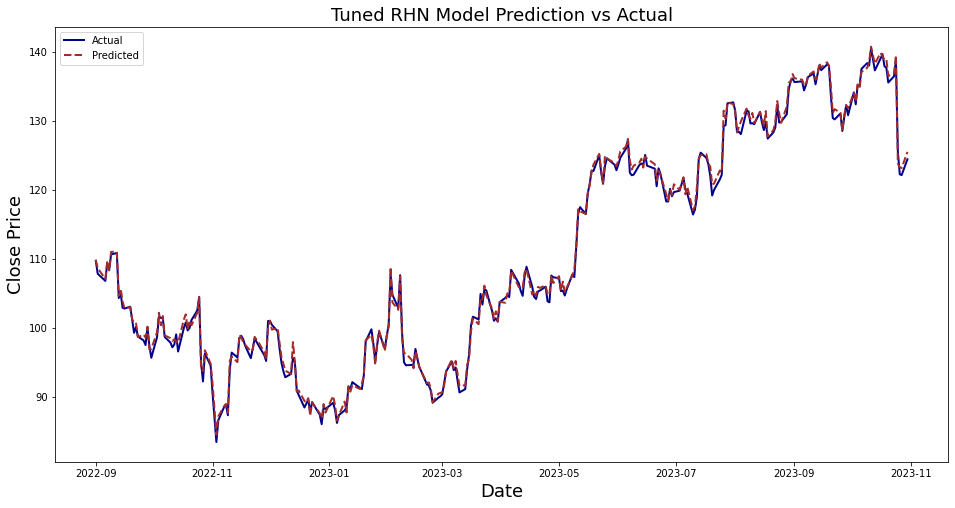

In [44]:
# Plot the predictions of RHN model with Hyperparameter tuning
plt.figure(figsize=(16,8))
plt.title('Tuned RHN Model Prediction vs Actual', fontsize=18)
plt.plot(df1.index[-len(y_test):], y_test_inv, linewidth=2, color='darkblue', label='Actual')
plt.plot(df1.index[-len(y_test):], pred_best_rhn_inv, linewidth=2, color='brown', label='Predicted', linestyle='--')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.legend(loc='best')
plt.show()

In [33]:
# Stacked LSTM-RHN model with hyperparameter tuning
stacked_tuned_pred = np.column_stack((pred_best_lstm, pred_best_rhn))

# Train final regressor based on stacked predictions
final_regressor_tuned = LinearRegression().fit(stacked_tuned_pred, y_test)

# Predict using the Stacked LSTM-RHN model
final_tuned_pred = final_regressor_tuned.predict(stacked_tuned_pred)

# Inverse the predictions
final_tuned_pred_inv = target_scaler.inverse_transform(final_tuned_pred.reshape(-1,1))

In [34]:
# Calculate the Evaluatioon metrics for Stacked model
stacked_tuned_mse = mean_squared_error(y_test_inv, final_tuned_pred_inv)
stacked_tuned_rmse = np.sqrt(stacked_tuned_mse)
stacked_tuned_mae = mean_absolute_error(y_test_inv, final_tuned_pred_inv)
stacked_tuned_r2 = r2_score(y_test_inv, final_tuned_pred_inv)

print("Tuned LSTM-RHN Model Evaluation Metrics")
print("=======================================")
print("MSE: {:.4f} ".format(stacked_tuned_mse))
print("RMSE: {:.4f}".format(stacked_tuned_rmse))
print("MAE: {:.4f}".format(stacked_tuned_mae))
print("R2 Score: {:.4f}".format(stacked_tuned_r2))

Tuned LSTM-RHN Model Evaluation Metrics
MSE: 0.3790 
RMSE: 0.6157
MAE: 0.4851
R2 Score: 0.9985


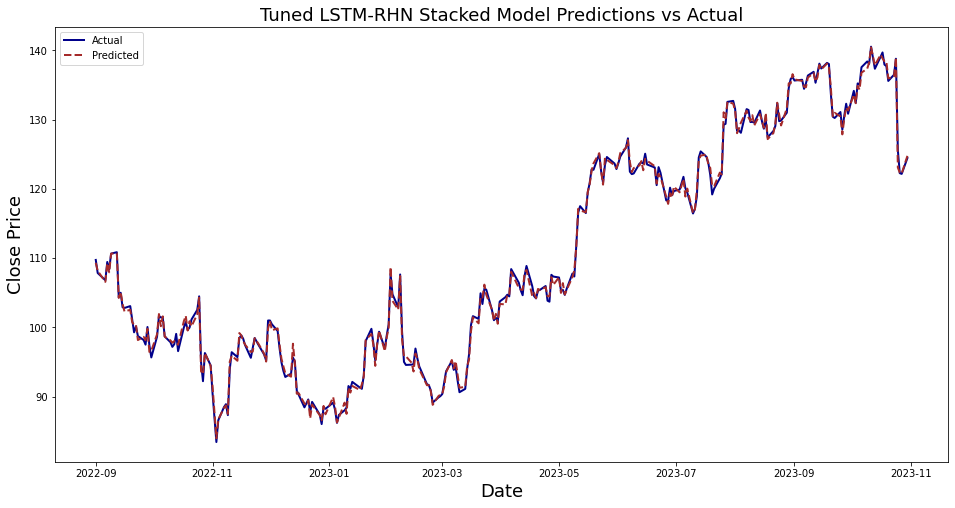

In [45]:
# Plot the predictions of Stacked model with Hyperparameter tuning
plt.figure(figsize=(16,8))
plt.title('Tuned LSTM-RHN Stacked Model Predictions vs Actual', fontsize=18)
plt.plot(df1.index[-len(y_test):], y_test_inv, linewidth=2, color='darkblue', label='Actual')
plt.plot(df1.index[-len(y_test):], final_tuned_pred_inv, linewidth=2, color='brown', label='Predicted', linestyle='--')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.legend(loc='best')
plt.show()

In [36]:
# Take the last day of data for predictions
last_features = X_scaled[-1:]

predicted_prices_best_lstm = []

# Predicting stock prices for the next 2 days
for _ in range(2):
    # Prepare the last features for LSTM input shape
    last_features_lstm = last_features.reshape(1, 1, X_train_lstm.shape[2])
    
    # Predicting the next day stock price using the last feature data
    predicted_best_price = best_lstm_model.predict(last_features_lstm)
    
    # Reshape the predicted price for inverse scaling
    predicted_best_price_reshaped = predicted_best_price.reshape(-1, 1)
    
    # Saving the predicted price after inverse transformation
    inverse_transformed_price = target_scaler.inverse_transform(predicted_best_price_reshaped)[0][0]
    predicted_prices_best_lstm.append(inverse_transformed_price)

    # Computing new features based on the predicted price
    new_features = np.array([
        last_features[0, 1],  # 'Open' value for the next day (shifted from 'High' of the current day)
        last_features[0, 2],  # 'High' value for the next day (shifted from 'Low' of the current day)
        predicted_best_price_reshaped[0, 0], # 'Low' value (using the predicted closing price as an approximation)
        (predicted_best_price_reshaped[0, 0] - last_features[0, 3]) / last_features[0, 3],  # Return for the predicted day
        np.mean(np.append(last_features[0, 4:6], predicted_best_price_reshaped[0, 0])),  # 5-day moving average
        np.mean(np.append(last_features[0, 5:], predicted_best_price_reshaped[0, 0])),  # 10-day moving average
        np.std(np.append(last_features[0, 6:], predicted_best_price_reshaped[0, 0]))    # 10-day moving standard deviation
    ], dtype=np.float32).reshape(1, 7)

    last_features = new_features

print("Predicted Closing Prices for the Next 2 Days (Best LSTM Model):")
for i, price in enumerate(predicted_prices_best_lstm):
    print(f"Day {i+1}:" "{:.3f}".format(price))

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 20ms/step
Predicted Closing Prices for the Next 2 Days (Best LSTM Model):
Day 1:126.270
Day 2:123.528


In [37]:
# Take the last day of data for predictions
last_features = X_scaled[-1:]

# Predict using the RHN model
predicted_prices_best_rhn = []

last_features_rhn = last_features.copy()

for _ in range(2):
    # Predicting the next day stock price using the last feature data
    predicted_best_price_rhn = best_rhn_model.predict(last_features_rhn)
    
    # Reshape the predicted price for inverse scaling
    predicted_price_reshaped_rhn = predicted_best_price_rhn.reshape(-1, 1)
    
    # Saving the predicted price after inverse transformation
    inverse_transformed_price_rhn = target_scaler.inverse_transform(predicted_price_reshaped_rhn)[0][0]
    predicted_prices_best_rhn.append(inverse_transformed_price_rhn)

    # Computing new features based on the predicted price
    new_features_rhn = np.array([
        last_features_rhn[0, 1], 
        last_features_rhn[0, 2], 
        predicted_price_reshaped_rhn[0, 0], 
        (predicted_price_reshaped_rhn[0, 0] - last_features_rhn[0, 3]) / last_features_rhn[0, 3],
        np.mean(np.append(last_features_rhn[0, 4:6], predicted_price_reshaped_rhn[0, 0])),
        np.mean(np.append(last_features_rhn[0, 5:], predicted_price_reshaped_rhn[0, 0])),
        np.std(np.append(last_features_rhn[0, 6:], predicted_price_reshaped_rhn[0, 0]))
    ], dtype=np.float32).reshape(1, 7)

    last_features_rhn = new_features_rhn

print("\nPredicted Closing Prices for the Next 2 Days (Best RHN Model):")
for i, price in enumerate(predicted_prices_best_rhn):
    print(f"Day {i+1}:" "{:.3f}".format(price))



Predicted Closing Prices for the Next 2 Days (Best RHN Model):
Day 1:125.533
Day 2:122.451


In [38]:
last_features = X_scaled[-1:]

# Predict using the Stacked LSTM-RHN model
predicted_prices_best_stacked = []

for day in range(2):
    # Reshape the last features for LSTM input shape
    last_features_lstm = last_features.reshape(1, 1, X_train_lstm.shape[2])
    
    # Predict using LSTM & RHN models
    lstm_pred_for_stacking = best_lstm_model.predict(last_features_lstm).flatten()
    rhn_pred_for_stacking = best_rhn_model.predict(last_features).flatten()

    # Stacking LSTM and rhn predictions
    stacked_predictions = np.column_stack((lstm_pred_for_stacking, rhn_pred_for_stacking))
    
    # Predict using the final regressor
    predicted_stacked = final_regressor.predict(stacked_predictions)

    # Reshape the predicted price for inverse scaling
    predicted_price_reshaped_stacked = predicted_stacked.reshape(-1, 1)
    
    # Saving the predicted price after inverse transformation
    inverse_transformed_price_stacked = target_scaler.inverse_transform(predicted_price_reshaped_stacked)[0][0]
    predicted_prices_best_stacked.append(inverse_transformed_price_stacked)

    # For the next prediction, update the features with the newly predicted price.
    new_features_stacked = np.array([
        last_features[0, 1], 
        last_features[0, 2], 
        predicted_price_reshaped_stacked[0, 0], 
        (predicted_price_reshaped_stacked[0, 0] - last_features[0, 3]) / last_features[0, 3],
        np.mean(np.append(last_features[0, 4:6], predicted_price_reshaped_stacked[0, 0])),
        np.mean(np.append(last_features[0, 5:], predicted_price_reshaped_stacked[0, 0])),
        np.std(np.append(last_features[0, 6:], predicted_price_reshaped_stacked[0, 0]))
    ], dtype=np.float32).reshape(1, 7)

    last_features = new_features_stacked

print("Predicted Closing Prices for the Next 2 Days (Best Stacked LSTM-RHN Model):")
for i, price in enumerate(predicted_prices_best_stacked):
    print(f"Day {i+1}:" "{:.3f}".format(price))

1/1 [==============================] - 0s 21ms/step
Predicted Closing Prices for the Next 2 Days (Best Stacked LSTM-RHN Model):
Day 1:124.711
Day 2:121.151


In [39]:
# Build a dataframe with actual and predicted prices for the best models
df_pred_1 = pd.DataFrame({'Date': df1.index[-len(y_test):], 'Actual': y_test_inv.flatten(),'Tuned LSTM': pred_best_lstm_inv.flatten(), 'Tuned RHN': pred_best_rhn_inv.flatten(), 'Tuned LSTM-RHN': final_tuned_pred_inv.flatten()})
df_pred_1

,Date,Actual,Tuned LSTM,Tuned RHN,Tuned LSTM-RHN
0,2022-09-01,109.739998,110.222313,109.849724,109.319832
1,2022-09-02,107.849998,108.977303,108.663933,108.161446
2,2022-09-06,106.809998,107.493240,107.092125,106.572128
3,2022-09-07,109.449997,109.840607,109.718719,109.270950
4,2022-09-08,108.379997,108.275322,108.329353,107.948212
...,...,...,...,...,...
287,2023-10-24,138.809998,139.416183,139.545349,138.972061
288,2023-10-25,125.610001,124.541008,123.823776,123.085327
289,2023-10-26,122.279999,124.667091,123.308693,122.366135
290,2023-10-27,122.169998,124.658096,123.191742,122.215012
